# Ep300 validation analysis and visualization
- goal: process and analyze qPCR results from Ep300 validation experiments
- input: qPCR measurements from Ep300 validation experiments (chemical inhibition & CRISPR KO)
- output: log (fold change) compared to control conditions, statistical test results and visualizations

In [1]:
# libraries
library(tidyverse)
library(ggplot2)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(tibble.width = Inf)

In [3]:
# helper functions

# default plotting theme
macro_theme <- function(){
    
    # settings
    font <- "Arial"
    size <- 8
    
    theme_bw(
        base_size=size,
        base_family = font
    ) %+replace% 
    
    theme(
      #grid elements
#       panel.grid.major = element_blank(),    #strip major gridlines
#       panel.grid.minor = element_blank(),    #strip minor gridlines
#       axis.ticks = element_blank(),          #strip axis ticks
      
#       strips axis lines ?
      
      #text elements
        text = element_text(              
                   family = font,           
                   size = size),
        
      plot.title = element_text(             #title
                   family = font,            #set font family
                   size = size,                #set font size
                   face = 'bold',            #bold typeface
                   hjust = 0.5,                #center align
                   vjust = 2),               #raise slightly
      
      plot.subtitle = element_text(          #subtitle
                   family = font,            #font family
                   size = size),               #font size
      
      plot.caption = element_text(           #caption
                   family = font,            #font family
                   size = size,                 #font size
                   hjust = 0.5),               #center align
      
      axis.title = element_text(             #axis titles
                   family = font,            #font family
                   size = size),               #font size
      
      axis.text = element_text(              #axis text
                   family = font,            #axis famuly
                   size = size),                #font size
        
        legend.text = element_text(              #axis text
                   family = font,            #axis famuly
                   size = size), 
        
        legend.title = element_text(              #axis text
                   family = font,            #axis famuly
                   size = size),
      
#       axis.text.x = element_text(            #margin for axis text
#                     margin=margin(5, b = 10))
    )
}

# extended ggsave
ggsave_new <- function(filename, results_path, plot, width=5, height=5, dpi=300){    
    ggsave(
          paste0(filename,'.pdf'),
          plot = plot,
          device = cairo_pdf,
          path = file.path(results_path),
          scale = 1,
          dpi = dpi,
            width = width,
            height = height,
          limitsize = FALSE,
        )
}

In [4]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/macrophage-regulation/src"

[1] "/home/sreichl/projects/macrophage-regulation"

# configs

In [5]:
# configs
data_path <- file.path('Ep300_validation')

# Load & prepare pimer efficiency data

In [6]:
# load standard PCR curves
std_curves <- read_csv(file.path(data_path,"Ep300_inh_qPCR_standardcurves.csv")) %>%
  filter(!is.na(Cq), !is.na(Primer), !Content %in% c("NTC","NoRT","Empty"), !Dilution %in% c("NTC","Empty"))

std_curves$Dilution <- as.numeric(std_curves$Dilution)

print(dim(std_curves))
head(std_curves)

Rows: 96 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Well, Fluor, Content, Primer, Dilution
dbl (2): Cq, SQ
lgl (2): Target, Sample

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 70  9


Well,Fluor,Target,Content,Sample,Cq,SQ,Primer,Dilution
<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>
A01,SYBR,NA,Unkn,NA,20.51799,NaN,Actb,1.00
A02,SYBR,NA,Unkn,NA,20.36558,NaN,Actb,1.00
A03,SYBR,NA,Unkn,NA,23.68585,NaN,Actb,0.10
A04,SYBR,NA,Unkn,NA,23.49986,NaN,Actb,0.10
A05,SYBR,NA,Unkn,NA,27.16082,NaN,Actb,0.01
A06,SYBR,NA,Unkn,NA,27.05115,NaN,Actb,0.01


In [7]:
# determine primer efficiencies
# Group data by primer to calculate efficiency for each one.
# The efficiency is derived from the slope of a regression line, modeling the relationship between Cq and log10(Dilution).
efficiencies <- std_curves %>%
  group_by(Primer) %>%
  summarize(
    slope       = lm(Cq ~ log10(Dilution))$coefficients[2],
    efficiency  = 10^(-1/slope)
  )

print(dim(efficiencies))
efficiencies

[1] 7 3


Primer,slope,efficiency
<chr>,<dbl>,<dbl>
Actb,-3.829455,1.824458
Gbp2,-3.557435,1.910299
Ifit1,-3.512142,1.926311
Irf7,-4.004011,1.777254
Oasl2,-3.789708,1.836000
Spp1,-3.698162,1.863823
Usp18,-4.090261,1.755833


# Chemical inhibition of Ep300 with SGC-CBP30 & A-485

## Load & prepare data

In [8]:
inh_raw_data <- read_csv(file.path(data_path,"Ep300_inh_1-36_RAW.csv")) %>%
  filter(!is.na(Cq), !is.na(Primer), !Content %in% c("NTC","NoRT","Empty"))

print(dim(inh_raw_data))
head(inh_raw_data)

Rows: 576 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Well, Fluor, Content, Condition, Timepoint, Drug, Stimulation, Prim...
dbl (4): Cq, SQ, Harvest, Replicate
lgl (2): Target, Sample

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 504  15


Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Replicate,Condition,Timepoint,Drug,Stimulation,Primer,Housekeeping
<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A01,SYBR,NA,Unkn,NA,23.03735,NaN,1,1,2h DMSO Unchallenged,2h,DMSO,Unchallenged,Actb,Yes
A02,SYBR,NA,Unkn,NA,22.95335,NaN,1,1,2h DMSO Unchallenged,2h,DMSO,Unchallenged,Actb,Yes
A03,SYBR,NA,Unkn,NA,22.82553,NaN,1,1,2h SGC-CBP30 Unchallenged,2h,SGC-CBP30,Unchallenged,Actb,Yes
A04,SYBR,NA,Unkn,NA,22.89384,NaN,1,1,2h SGC-CBP30 Unchallenged,2h,SGC-CBP30,Unchallenged,Actb,Yes
A05,SYBR,NA,Unkn,NA,22.37539,NaN,1,1,2h A485 Unchallenged,2h,A485,Unchallenged,Actb,Yes
A06,SYBR,NA,Unkn,NA,22.26226,NaN,1,1,2h A485 Unchallenged,2h,A485,Unchallenged,Actb,Yes


In [9]:
# add primer efficiencies to raw data
inh_analysis_data <- inh_raw_data %>%
  left_join(efficiencies, by = "Primer")

print(dim(inh_analysis_data))
head(inh_analysis_data)

[1] 504  17


Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Replicate,Condition,Timepoint,Drug,Stimulation,Primer,Housekeeping,slope,efficiency
<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
A01,SYBR,NA,Unkn,NA,23.03735,NaN,1,1,2h DMSO Unchallenged,2h,DMSO,Unchallenged,Actb,Yes,-3.829455,1.824458
A02,SYBR,NA,Unkn,NA,22.95335,NaN,1,1,2h DMSO Unchallenged,2h,DMSO,Unchallenged,Actb,Yes,-3.829455,1.824458
A03,SYBR,NA,Unkn,NA,22.82553,NaN,1,1,2h SGC-CBP30 Unchallenged,2h,SGC-CBP30,Unchallenged,Actb,Yes,-3.829455,1.824458
A04,SYBR,NA,Unkn,NA,22.89384,NaN,1,1,2h SGC-CBP30 Unchallenged,2h,SGC-CBP30,Unchallenged,Actb,Yes,-3.829455,1.824458
A05,SYBR,NA,Unkn,NA,22.37539,NaN,1,1,2h A485 Unchallenged,2h,A485,Unchallenged,Actb,Yes,-3.829455,1.824458
A06,SYBR,NA,Unkn,NA,22.26226,NaN,1,1,2h A485 Unchallenged,2h,A485,Unchallenged,Actb,Yes,-3.829455,1.824458


In [10]:
# separate housekeeping reference from target genes and average across wells (using Actb as reference)
ref_data <- inh_analysis_data %>%
  filter(Housekeeping == "Yes") %>%
  group_by(Replicate, Timepoint, Drug, Stimulation, Harvest) %>%
  summarize(refCq = mean(Cq, na.rm=TRUE), .groups="drop")

target_data <- inh_analysis_data %>%
  filter(Housekeeping == "No")

# join ref with targets and compute dCq on lowest group level(!)
joined_data <- target_data %>%
  left_join(ref_data, by=c("Replicate","Timepoint", "Drug", "Stimulation","Harvest")) %>%
  mutate(dCq = Cq - refCq)

# summarize per replicate, primer, condition by averaging dCq values across Wells and Harvests
summ_data <- joined_data %>%
  group_by(Replicate, Timepoint, Drug, Stimulation, Primer, efficiency) %>%
  summarize(mean_dCq = mean(dCq, na.rm=TRUE), .groups="drop")

# get DMSO reference mean_dCq on replicate-basis
ref_summ <- summ_data %>%
  filter(Drug == "DMSO") %>%
  group_by(Replicate, Timepoint, Stimulation, Primer) %>%
  summarize(DMSO_mean_dCq = mean(mean_dCq, na.rm=TRUE), .groups="drop")

## Method 1: ΔΔCq
assuming primer efficiency of 2

In [11]:
# add ΔΔCq method results
results <- summ_data %>%
  left_join(ref_summ, by=c("Replicate","Timepoint","Stimulation","Primer")) %>%
  mutate(ddCq = mean_dCq - DMSO_mean_dCq,
         fold_ddCq = 2^(-ddCq),
         log2FC_ddCq = log2(fold_ddCq))

In [12]:
print(dim(results))
head(results)

[1] 216  11


Replicate,Timepoint,Drug,Stimulation,Primer,efficiency,mean_dCq,DMSO_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24h,A485,2h IFNb,Gbp2,1.910299,0.5019391,2.7051777,-2.2032387,4.605120,2.2032387
1,24h,A485,2h IFNb,Ifit1,1.926311,0.5952359,2.3197167,-1.7244809,3.304612,1.7244809
1,24h,A485,2h IFNb,Irf7,1.777254,-0.8368944,0.6543379,-1.4912323,2.811290,1.4912323
1,24h,A485,2h IFNb,Oasl2,1.836000,1.3579273,2.2640297,-0.9061024,1.873976,0.9061024
1,24h,A485,2h IFNb,Spp1,1.863823,3.1893186,3.5271987,-0.3378801,1.263898,0.3378801
1,24h,A485,2h IFNb,Usp18,1.755833,-2.1635826,-1.3824717,-0.7811108,1.718454,0.7811108


In [13]:
results[results$Drug=="DMSO",]

Replicate,Timepoint,Drug,Stimulation,Primer,efficiency,mean_dCq,DMSO_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24h,DMSO,2h IFNb,Gbp2,1.910299,2.7051777,2.7051777,0,1,0
1,24h,DMSO,2h IFNb,Ifit1,1.926311,2.3197167,2.3197167,0,1,0
1,24h,DMSO,2h IFNb,Irf7,1.777254,0.6543379,0.6543379,0,1,0
1,24h,DMSO,2h IFNb,Oasl2,1.836000,2.2640297,2.2640297,0,1,0
1,24h,DMSO,2h IFNb,Spp1,1.863823,3.5271987,3.5271987,0,1,0
1,24h,DMSO,2h IFNb,Usp18,1.755833,-1.3824717,-1.3824717,0,1,0
1,24h,DMSO,Unchallenged,Gbp2,1.910299,9.8206958,9.8206958,0,1,0
1,24h,DMSO,Unchallenged,Ifit1,1.926311,6.0916339,6.0916339,0,1,0
1,24h,DMSO,Unchallenged,Irf7,1.777254,0.8594167,0.8594167,0,1,0


## Method 2: Pfaffl
using measured primer efficiency

In [14]:
# add Pfaffl method results
results <- results %>%
  mutate(fold_pfaffl   = efficiency^(-ddCq),
         log2FC_pfaffl = log2(fold_pfaffl))

In [15]:
print(dim(results))
head(results)

[1] 216  13


Replicate,Timepoint,Drug,Stimulation,Primer,efficiency,mean_dCq,DMSO_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq,fold_pfaffl,log2FC_pfaffl
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24h,A485,2h IFNb,Gbp2,1.910299,0.5019391,2.7051777,-2.2032387,4.605120,2.2032387,4.162301,2.0573812
1,24h,A485,2h IFNb,Ifit1,1.926311,0.5952359,2.3197167,-1.7244809,3.304612,1.7244809,3.097458,1.6310847
1,24h,A485,2h IFNb,Irf7,1.777254,-0.8368944,0.6543379,-1.4912323,2.811290,1.4912323,2.357407,1.2372009
1,24h,A485,2h IFNb,Oasl2,1.836000,1.3579273,2.2640297,-0.9061024,1.873976,0.9061024,1.734186,0.7942583
1,24h,A485,2h IFNb,Spp1,1.863823,3.1893186,3.5271987,-0.3378801,1.263898,0.3378801,1.234140,0.3035058
1,24h,A485,2h IFNb,Usp18,1.755833,-2.1635826,-1.3824717,-0.7811108,1.718454,0.7811108,1.552274,0.6343835


## Compare methods by log2 fold changes

Conclusion: highjly correlate, ddCq slightly higher, but pfaffl more rigoros.

In [16]:
log2fc_corr <- results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(log2FC_ddCq, log2FC_pfaffl, use = "complete.obs"), .groups = "drop")

log2fc_corr

Primer,correlation
<chr>,<dbl>
Gbp2,1
Ifit1,1
Irf7,1
Oasl2,1
Spp1,1
Usp18,1


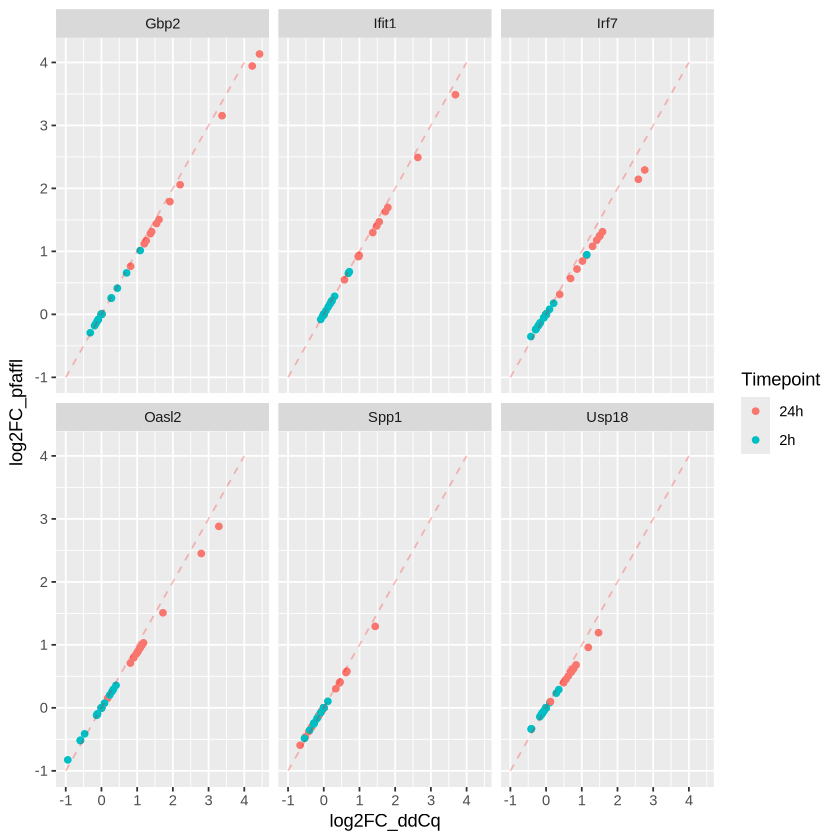

In [17]:
ggplot(results, aes(x=log2FC_ddCq, y=log2FC_pfaffl)) +
  geom_point(aes(color=Timepoint)) +
  facet_wrap(~Primer, scales="fixed") + 
annotate("segment", x = -1, y = -1, xend = 4, yend = 4, 
           color = "red", linetype = "dashed", alpha=0.25)

## Statistical analysis 

In [18]:
# For each Primer, Timepoint, Stimulation, and Drug (excluding DMSO, as its the control) combination, t-test log2FC vs 0
stat_results <- results %>%
  filter(Drug != "DMSO") %>%
  group_by(Primer, Timepoint, Drug, Stimulation) %>%
  summarize(
    n          = n(),
      # ddCq
    mean_log2FC_ddCq  = mean(log2FC_ddCq, na.rm=TRUE),
    sd_log2FC_ddCq    = sd(log2FC_ddCq, na.rm=TRUE),
    # t_pvalue_ddCq   = t.test(log2FC_ddCq, mu=0)$p.value, # same as paired t-test with c(0,0,0)
    t_pvalue_ddCq   = t.test(log2FC_ddCq, c(0,0,0), paired=TRUE)$p.value,
      
      # pfaffl
    mean_log2FC_pfaffl  = mean(log2FC_pfaffl, na.rm=TRUE),
    sd_log2FC_pfaffl    = sd(log2FC_pfaffl, na.rm=TRUE),
    # t_pvalue_pfaffl   = t.test(log2FC_pfaffl, mu=0)$p.value, # same as paired t-test with c(0,0,0)
    t_pvalue_pfaffl   = t.test(log2FC_pfaffl, c(0,0,0), paired=TRUE)$p.value,
    .groups    = "drop"
  )

print(dim(stat_results))
head(stat_results)

[1] 48 11


Primer,Timepoint,Drug,Stimulation,n,mean_log2FC_ddCq,sd_log2FC_ddCq,t_pvalue_ddCq,mean_log2FC_pfaffl,sd_log2FC_pfaffl,t_pvalue_pfaffl
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gbp2,24h,A485,2h IFNb,3,1.7910898,0.48749850,0.023815353,1.6725171,0.45522542,0.023815353
Gbp2,24h,A485,Unchallenged,3,4.0093115,0.55625360,0.006355202,3.7438895,0.51942884,0.006355202
Gbp2,24h,SGC-CBP30,2h IFNb,3,1.4406941,0.09065453,0.001317211,1.3453182,0.08465308,0.001317211
Gbp2,24h,SGC-CBP30,Unchallenged,3,1.2096360,0.39753721,0.034167414,1.1295564,0.37121970,0.034167414
Gbp2,2h,A485,2h IFNb,3,0.4234648,0.60098466,0.346665810,0.3954308,0.56119865,0.346665810
Gbp2,2h,A485,Unchallenged,3,0.3444789,0.41978407,0.291118920,0.3216739,0.39199379,0.291118920


# A tibble: 6 × 2
  Primer correlation
  <chr>        <dbl>
1 Gbp2             1
2 Ifit1            1
3 Irf7             1
4 Oasl2            1
5 Spp1             1
6 Usp18            1


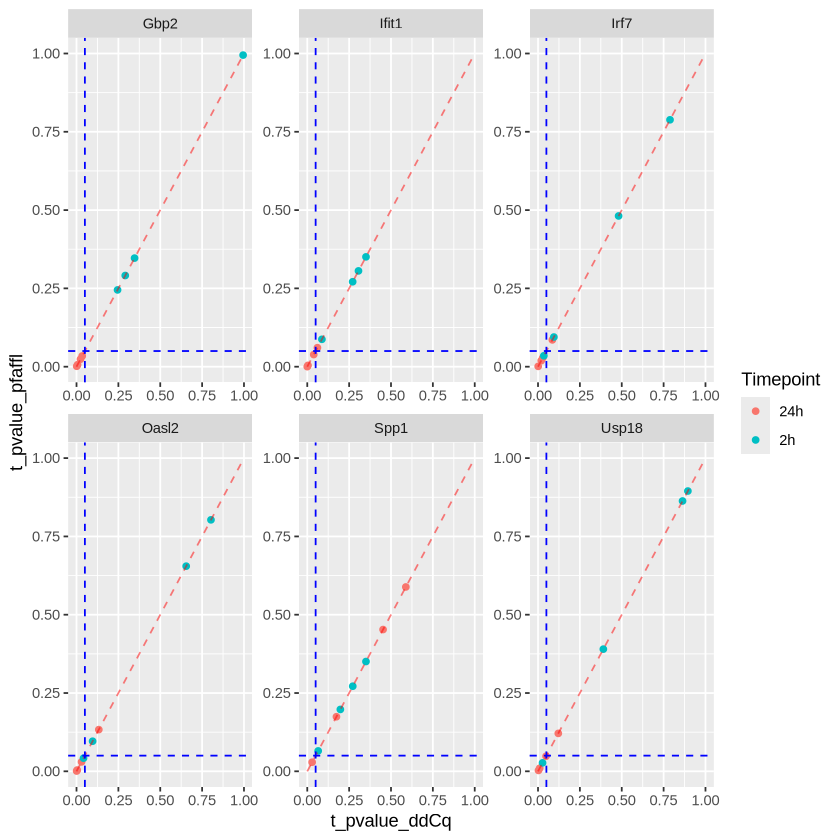

In [19]:
# compare p-values
pval_corr <- stat_results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(t_pvalue_ddCq, t_pvalue_pfaffl, use = "complete.obs"), .groups = "drop")
print(pval_corr)

ggplot(stat_results, aes(x=t_pvalue_ddCq, y=t_pvalue_pfaffl)) +
  geom_point(aes(color=Timepoint)) +
  facet_wrap(~Primer, scales="free") +
annotate("segment", x = 0, y = 0, xend = 1, yend = 1, 
           color = "red", linetype = "dashed", alpha=0.5) +
geom_hline(yintercept = 0.05, linetype = "dashed", color = "blue") +
  geom_vline(xintercept = 0.05, linetype = "dashed", color = "blue")


## Save results

In [20]:
# save results
write_csv(results, file.path(data_path, "Ep300_inh_pfaffl_qPCR_results.csv"))
write_csv(stat_results, file.path(data_path, "Ep300_inh_pfaffl_qPCR_statistics.csv"))

## Visualization 

In [21]:
width <- 10
height <- 4
options(repr.plot.width=width, repr.plot.height=height)

In [22]:
# remove DMSO data for plotting and reorder columns
results_plot <- results %>%
  filter(Drug != "DMSO")%>%
mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Drug   = factor(Drug,   levels = c("SGC-CBP30","A485"))
  )

In [23]:
head(results_plot)

Replicate,Timepoint,Drug,Stimulation,Primer,efficiency,mean_dCq,DMSO_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq,fold_pfaffl,log2FC_pfaffl
<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24h,A485,2h IFNb,Gbp2,1.910299,0.5019391,2.7051777,-2.2032387,4.605120,2.2032387,4.162301,2.0573812
1,24h,A485,2h IFNb,Ifit1,1.926311,0.5952359,2.3197167,-1.7244809,3.304612,1.7244809,3.097458,1.6310847
1,24h,A485,2h IFNb,Irf7,1.777254,-0.8368944,0.6543379,-1.4912323,2.811290,1.4912323,2.357407,1.2372009
1,24h,A485,2h IFNb,Oasl2,1.836000,1.3579273,2.2640297,-0.9061024,1.873976,0.9061024,1.734186,0.7942583
1,24h,A485,2h IFNb,Spp1,1.863823,3.1893186,3.5271987,-0.3378801,1.263898,0.3378801,1.234140,0.3035058
1,24h,A485,2h IFNb,Usp18,1.755833,-2.1635826,-1.3824717,-0.7811108,1.718454,0.7811108,1.552274,0.6343835


In [24]:
# mark p-values <= 0.05 with an asterisk
stats_results <- stat_results %>%
mutate(sig_label = ifelse(t_pvalue_pfaffl <= 0.05, "*", ""))

star_positions <- results_plot %>%
  group_by(Primer, Timepoint, Drug, Stimulation) %>%
  summarize(
    ypos = max(log2FC_pfaffl, na.rm = TRUE),
    .groups = "drop"
  )

stats_for_plot <- star_positions %>%
  left_join(stats_results, by = c("Primer","Timepoint", "Drug", "Stimulation"))%>%
  mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Drug   = factor(Drug,   levels = c("SGC-CBP30","A485"))
  )

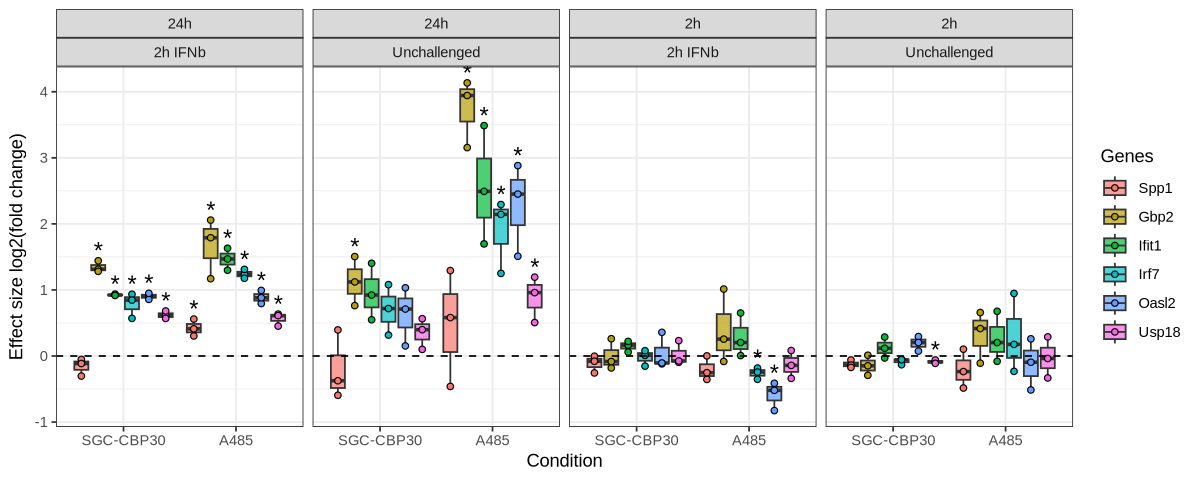

In [25]:
# plot as box plots
p_results <- results_plot %>%
  ggplot(aes(
    x      = Drug, 
    y      = log2FC_pfaffl, 
    fill   = Primer
  ), color  = "black") +
  # Boxplot, grouped by both Drug & Primer
  geom_boxplot(
    aes(group = interaction(Drug, Primer)),
    position = position_dodge(width = 0.9),
    alpha    = 0.7,
    outlier.shape = NA
  ) +
  # replicate points
  geom_point(
    aes(group = interaction(Drug, Primer)),
    position = position_dodge(width=0.9),
    size     = 1.5,
    shape    = 21,
    stroke   = 0.5
  ) +
  # Horizontal reference line at 0
  geom_hline(yintercept = 0, linetype = "dashed") +
  # Facet in one row
  facet_wrap(~ Timepoint + Stimulation, ncol = 4, scales = "fixed") +
  # Axis & legend labels
  labs(
    x    = "Condition",
    y    = "Effect size log2(fold change)",
    fill = "Genes",
    color= "Genes"
  ) +
  theme_bw() +
  # Add significance stars (if p<=0.05 => "*")
    geom_text(
        data     = stats_for_plot,
        aes(group = interaction(Drug, Primer),
            y     = ypos,
           label=sig_label
           ),
            position = position_dodge(width = 0.9),
    vjust    = -0.1,
    size     = 5,
    )+
scale_color_identity(guide = "none")

p_results

In [26]:
# save plot
ggsave_new(filename="Ep300_inh_pfaffl_qPCR",
           results_path=data_path,
           plot=p_results+ macro_theme(),
           width=width,
           height=height
          )

# CRISPR KO of Ep300 w/ 2h IFNb treatment

## Load & prepare data

In [27]:
raw_data <- read_csv(file.path(data_path,"Ep300_ko_IFNb_1-15_untreated_RAW.csv")) %>%
  filter(!is.na(Cq), !is.na(Primer), !Content %in% c("NTC","NoRT","Empty"), Primer!="Ifit2")

print(dim(raw_data))
head(raw_data)

Rows: 288 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Well, Fluor, Content, Guide, Primer, Housekeeping
dbl (3): Cq, SQ, Harvest
lgl (2): Target, Sample

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 210  11


Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Guide,Primer,Housekeeping
<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
A01,SYBR,NA,Unkn,NA,24.01168,NaN,1,NT-1,Actb,Yes
A02,SYBR,NA,Unkn,NA,24.02496,NaN,1,NT-1,Actb,Yes
A03,SYBR,NA,Unkn,NA,24.28499,NaN,1,NT-2,Actb,Yes
A04,SYBR,NA,Unkn,NA,24.35231,NaN,1,NT-2,Actb,Yes
A05,SYBR,NA,Unkn,NA,24.44243,NaN,1,EP300-1,Actb,Yes
A06,SYBR,NA,Unkn,NA,24.41014,NaN,1,EP300-1,Actb,Yes


In [28]:
# add primer efficiencies to raw data
analysis_data <- raw_data %>%
  left_join(efficiencies, by = "Primer")

print(dim(analysis_data))
head(analysis_data)

[1] 210  13


Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Guide,Primer,Housekeeping,slope,efficiency
<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
A01,SYBR,NA,Unkn,NA,24.01168,NaN,1,NT-1,Actb,Yes,-3.829455,1.824458
A02,SYBR,NA,Unkn,NA,24.02496,NaN,1,NT-1,Actb,Yes,-3.829455,1.824458
A03,SYBR,NA,Unkn,NA,24.28499,NaN,1,NT-2,Actb,Yes,-3.829455,1.824458
A04,SYBR,NA,Unkn,NA,24.35231,NaN,1,NT-2,Actb,Yes,-3.829455,1.824458
A05,SYBR,NA,Unkn,NA,24.44243,NaN,1,EP300-1,Actb,Yes,-3.829455,1.824458
A06,SYBR,NA,Unkn,NA,24.41014,NaN,1,EP300-1,Actb,Yes,-3.829455,1.824458


In [29]:
# separate housekeeping reference from target genes and average across wells (using Actb as reference)
ref_data <- analysis_data %>%
  filter(Housekeeping == "Yes") %>%
  group_by(Guide, Harvest) %>%
  summarize(refCq = mean(Cq, na.rm=TRUE), .groups="drop")

target_data <- analysis_data %>%
  filter(Housekeeping == "No")

# join ref with targets and compute dCq on lowest group level(!)
joined_data <- target_data %>%
  left_join(ref_data, by=c("Guide","Harvest")) %>%
  mutate(dCq = Cq - refCq)

# summarize per primer and guide by averaging dCq values across Wells
summ_data <- joined_data %>%
  group_by(Guide, Primer, Harvest, efficiency) %>%
  summarize(mean_dCq = mean(dCq, na.rm=TRUE), .groups="drop")

# get NT-1 reference mean_dCq on replicate-basis
ref_summ <- summ_data %>%
  filter(Guide == "NT-1") %>%
  group_by(Primer, Harvest) %>%
  summarize(ref_mean_dCq = mean(mean_dCq, na.rm=TRUE), .groups="drop")

## Method 1: ΔΔCq
assuming primer efficiency of 2

In [30]:
# add ΔΔCq method results
results <- summ_data %>%
  left_join(ref_summ, by=c("Primer", "Harvest")) %>%
  mutate(ddCq = mean_dCq - ref_mean_dCq,
         fold_ddCq = 2^(-ddCq),
         log2FC_ddCq = log2(fold_ddCq))

In [31]:
print(dim(results))
head(results)

[1] 90  9


Guide,Primer,Harvest,efficiency,mean_dCq,ref_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EP300-1,Gbp2,1,1.910299,0.7805454,2.0399970,-1.2594516,2.394047,1.2594516
EP300-1,Gbp2,2,1.910299,0.5460764,1.7019309,-1.1558546,2.228163,1.1558546
EP300-1,Gbp2,3,1.910299,0.4497715,2.0332993,-1.5835278,2.997018,1.5835278
EP300-1,Ifit1,1,1.926311,-2.1088309,-0.9919528,-1.1168781,2.168772,1.1168781
EP300-1,Ifit1,2,1.926311,-2.0573097,-1.1610698,-0.8962398,1.861209,0.8962398
EP300-1,Ifit1,3,1.926311,-1.8472294,-0.7263803,-1.1208491,2.174749,1.1208491


In [32]:
# check that ref ddCq are 0
head(results[results$Guide=="NT-1",])

Guide,Primer,Harvest,efficiency,mean_dCq,ref_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NT-1,Gbp2,1,1.910299,2.0399970,2.0399970,0,1,0
NT-1,Gbp2,2,1.910299,1.7019309,1.7019309,0,1,0
NT-1,Gbp2,3,1.910299,2.0332993,2.0332993,0,1,0
NT-1,Ifit1,1,1.926311,-0.9919528,-0.9919528,0,1,0
NT-1,Ifit1,2,1.926311,-1.1610698,-1.1610698,0,1,0
NT-1,Ifit1,3,1.926311,-0.7263803,-0.7263803,0,1,0


## Method 2: Pfaffl
using measured primer efficiency

In [33]:
# add Pfaffl method results
results <- results %>%
  mutate(fold_pfaffl   = efficiency^(-ddCq),
         log2FC_pfaffl = log2(fold_pfaffl))

In [34]:
print(dim(results))
head(results)

[1] 90 11


Guide,Primer,Harvest,efficiency,mean_dCq,ref_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq,fold_pfaffl,log2FC_pfaffl
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EP300-1,Gbp2,1,1.910299,0.7805454,2.0399970,-1.2594516,2.394047,1.2594516,2.259611,1.1760742
EP300-1,Gbp2,2,1.910299,0.5460764,1.7019309,-1.1558546,2.228163,1.1558546,2.113062,1.0793354
EP300-1,Gbp2,3,1.910299,0.4497715,2.0332993,-1.5835278,2.997018,1.5835278,2.786967,1.4786961
EP300-1,Ifit1,1,1.926311,-2.1088309,-0.9919528,-1.1168781,2.168772,1.1168781,2.079720,1.0563891
EP300-1,Ifit1,2,1.926311,-2.0573097,-1.1610698,-0.8962398,1.861209,0.8962398,1.799630,0.8477004
EP300-1,Ifit1,3,1.926311,-1.8472294,-0.7263803,-1.1208491,2.174749,1.1208491,2.085141,1.0601451


## Compare methods by log2 fold changes

Conclusion: highjly correlate, ddCq slightly higher, but pfaffl more rigoros.

In [35]:
log2fc_corr <- results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(log2FC_ddCq, log2FC_pfaffl, use = "complete.obs"), .groups = "drop")

log2fc_corr

Primer,correlation
<chr>,<dbl>
Gbp2,1
Ifit1,1
Irf7,1
Oasl2,1
Spp1,1
Usp18,1


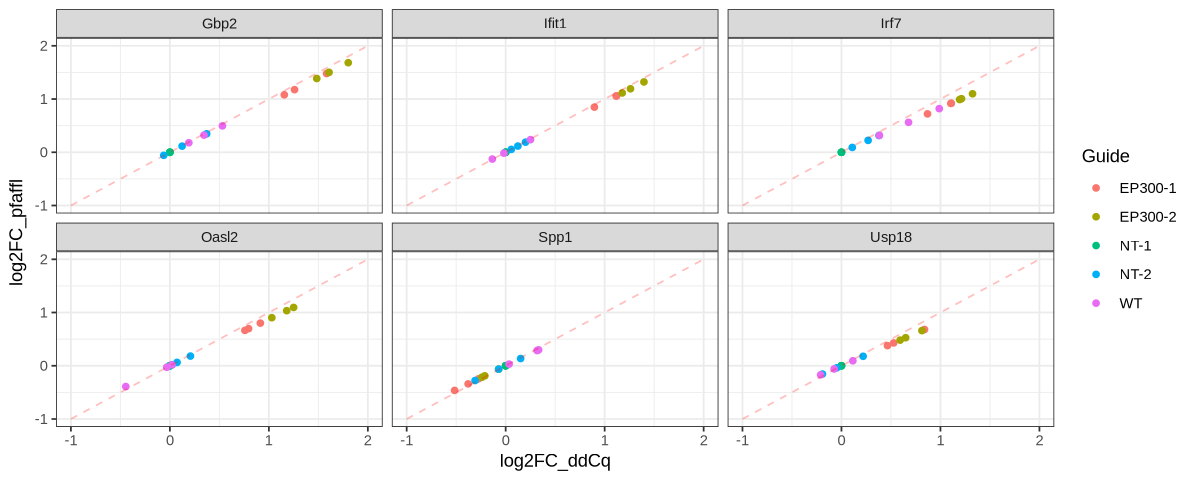

In [36]:
ggplot(results, aes(x=log2FC_ddCq, y=log2FC_pfaffl)) +
  geom_point(aes(color=Guide)) +
  facet_wrap(~Primer, scales="fixed") + 
annotate("segment", x = -1, y = -1, xend = 2, yend = 2, 
           color = "red", linetype = "dashed", alpha=0.25) +
theme_bw()

## Statistical analysis 

In [37]:
# For each Primer, Guide (excluding NT-1, as it is the control) combination, t-test log2FC vs 0
stat_results <- results %>%
  filter(Guide != "NT-1") %>%
  group_by(Primer, Guide) %>%
  summarize(
    n          = n(),
      # ddCq
    mean_log2FC_ddCq  = mean(log2FC_ddCq, na.rm=TRUE),
    sd_log2FC_ddCq    = sd(log2FC_ddCq, na.rm=TRUE),
    # t_pvalue_ddCq   = t.test(log2FC_ddCq, mu=0)$p.value, # same as paired t-test with c(0,0,0)
    t_pvalue_ddCq   = t.test(log2FC_ddCq, c(0,0,0), paired=TRUE)$p.value,
      # pfaffl
    mean_log2FC_pfaffl  = mean(log2FC_pfaffl, na.rm=TRUE),
    sd_log2FC_pfaffl    = sd(log2FC_pfaffl, na.rm=TRUE),
    # t_pvalue_pfaffl   = t.test(log2FC_pfaffl, mu=0)$p.value, # same as paired t-test with c(0,0,0)
    t_pvalue_pfaffl   = t.test(log2FC_pfaffl, c(0,0,0), paired=TRUE)$p.value,
    .groups    = "drop"
  )

print(dim(stat_results))
head(stat_results)

[1] 24  9


Primer,Guide,n,mean_log2FC_ddCq,sd_log2FC_ddCq,t_pvalue_ddCq,mean_log2FC_pfaffl,sd_log2FC_pfaffl,t_pvalue_pfaffl
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gbp2,EP300-1,3,1.3329447,0.2231077,0.009209825,1.2447019,0.2083376,0.009209825
Gbp2,EP300-2,3,1.6312159,0.1602546,0.003201747,1.5232271,0.1496455,0.003201747
Gbp2,NT-2,3,0.1443911,0.2174427,0.369042086,0.1348322,0.2030477,0.369042086
Gbp2,WT,3,0.3557792,0.1699805,0.068376134,0.3322261,0.1587276,0.068376134
Ifit1,EP300-1,3,1.0446557,0.1285472,0.005009392,0.9880782,0.1215853,0.005009392
Ifit1,EP300-2,3,1.2785328,0.1106669,0.002488097,1.2092887,0.1046733,0.002488097


# A tibble: 6 × 2
  Primer correlation
  <chr>        <dbl>
1 Gbp2             1
2 Ifit1            1
3 Irf7             1
4 Oasl2            1
5 Spp1             1
6 Usp18            1


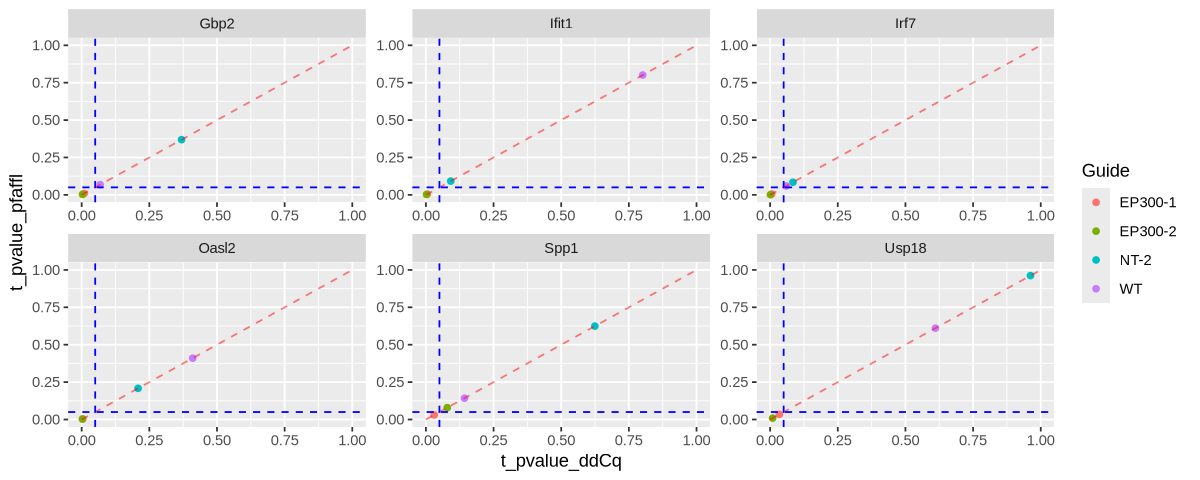

In [38]:
# compare p-values
pval_corr <- stat_results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(t_pvalue_ddCq, t_pvalue_pfaffl, use = "complete.obs"), .groups = "drop")
print(pval_corr)

ggplot(stat_results, aes(x=t_pvalue_ddCq, y=t_pvalue_pfaffl)) +
  geom_point(aes(color=Guide)) +
  facet_wrap(~Primer, scales="free") +
annotate("segment", x = 0, y = 0, xend = 1, yend = 1, 
           color = "red", linetype = "dashed", alpha=0.5) +
geom_hline(yintercept = 0.05, linetype = "dashed", color = "blue") +
  geom_vline(xintercept = 0.05, linetype = "dashed", color = "blue")


## Save results

In [39]:
# save results
write_csv(results, file.path(data_path, "Ep300_ko_IFNb_pfaffl_qPCR_results.csv"))
write_csv(stat_results, file.path(data_path, "Ep300_ko_IFNb_pfaffl_qPCR_statistics.csv"))

## Visualization 

In [40]:
width <- 6
height <- 4
options(repr.plot.width=width, repr.plot.height=height)

In [41]:
# remove DMSO data for plotting and reorder columns
results_plot <- results %>%
  filter(Guide != "NT-1")%>%
mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Guide   = factor(Guide,   levels = c("NT-2","WT", "EP300-1","EP300-2"))
  )

In [42]:
# mark p-values <= 0.05 with an asterisk
stats_results <- stat_results %>%
mutate(sig_label = ifelse(t_pvalue_pfaffl <= 0.05, "*", ""))

star_positions <- results_plot %>%
  group_by(Primer, Guide) %>%
  summarize(
    ypos = max(log2FC_pfaffl, na.rm = TRUE),
    .groups = "drop"
  )

stats_for_plot <- star_positions %>%
  left_join(stats_results, by = c("Primer","Guide"))%>%
  mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Guide   = factor(Guide,   levels = c("NT-2","WT", "EP300-1","EP300-2"))
  )

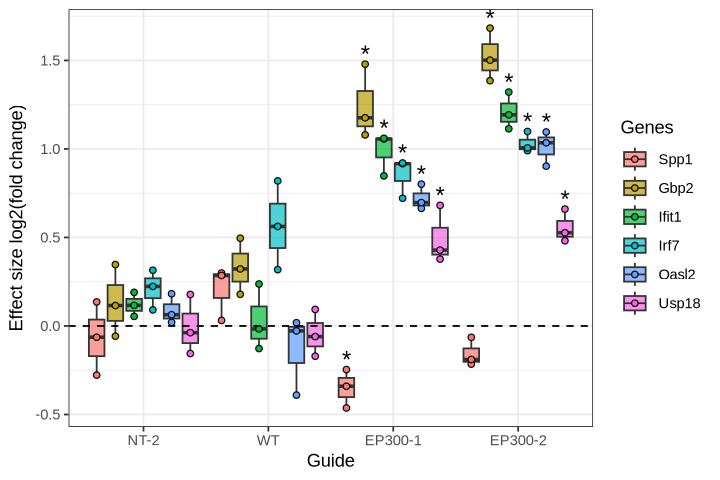

In [43]:
# plot as box plots
p_results <- results_plot %>%
  ggplot(aes(
    x      = Guide, 
    y      = log2FC_pfaffl, 
    fill   = Primer
  ), color  = "black") +
  # Boxplot, grouped by both Guide & Primer
  geom_boxplot(
    aes(group = interaction(Guide, Primer)),
    position = position_dodge(width = 0.9),
    alpha    = 0.7,
    outlier.shape = NA
  ) +
  # replicate points
  geom_point(
    aes(group = interaction(Guide, Primer)),
    position = position_dodge(width=0.9),
    size     = 1.5,
    shape    = 21,
    stroke   = 0.5
  ) +
  # Horizontal reference line at 0
  geom_hline(yintercept = 0, linetype = "dashed") +
  # Facet in one row
  # facet_wrap(~ Timepoint + Stimulation, ncol = 4, scales = "fixed") +
  # Axis & legend labels
  labs(
    x    = "Guide",
    y    = "Effect size log2(fold change)",
    fill = "Genes",
    color= "Genes"
  ) +
  theme_bw() +
  # Add significance stars (if p<=0.05 => "*")
    geom_text(
        data     = stats_for_plot,
        aes(group = interaction(Guide, Primer),
            y     = ypos,
           label=sig_label
           ),
            position = position_dodge(width = 0.9),
    vjust    = -0.1,
    size     = 5,
    )+
scale_color_identity(guide = "none")

p_results

In [44]:
# save plot
ggsave_new(filename="Ep300_ko_IFNb_pfaffl_qPCR",
           results_path=data_path,
           plot=p_results+ macro_theme(),
           width=width,
           height=height
          )

# CRISPR KO of Ep300 untreated

## Load & prepare data

In [45]:
raw_data_1 <- read_csv(file.path(data_path,"Ep300_ko_untreated_1_1-15_untreated_RAW.csv")) %>%
  filter(!is.na(Cq), !is.na(Primer), !Content %in% c("NTC","NoRT","Empty"), !Primer %in% c("Ifit2", "Actb"), !Guide %in% c("NTC","NoRT","Empty"))%>%
  mutate(Plate = 1)

raw_data_2 <- read_csv(file.path(data_path,"Ep300_ko_untreated_2_1-15_untreated_RAW.csv")) %>%
  filter(!is.na(Cq), !is.na(Primer), !Content %in% c("NTC","NoRT","Empty"), !Primer %in% c("Ifit2", "Actb"), !Guide %in% c("NTC","NoRT","Empty"))%>%
  mutate(Plate = 2)

# combine plates
raw_data <- bind_rows(raw_data_1, raw_data_2)

# move plate info to start
raw_data <- raw_data %>%
  select(Plate, everything())

print(dim(raw_data))
head(raw_data)

Rows: 288 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Well, Fluor, Content, Guide, Primer, Housekeeping
dbl (3): Cq, SQ, Harvest
lgl (2): Target, Sample

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 288 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Well, Fluor, Content, Guide, Primer, Housekeeping
dbl (3): Cq, SQ, Harvest
lgl (2): Target, Sample

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 240  12


Plate,Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Guide,Primer,Housekeeping
<dbl>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,A01,SYBR,NA,Unkn,NA,22.05983,NaN,1,NT-1,Gapdh,Yes
1,A02,SYBR,NA,Unkn,NA,22.04948,NaN,1,NT-1,Gapdh,Yes
1,A03,SYBR,NA,Unkn,NA,21.69522,NaN,1,NT-2,Gapdh,Yes
1,A04,SYBR,NA,Unkn,NA,22.43506,NaN,1,NT-2,Gapdh,Yes
1,A05,SYBR,NA,Unkn,NA,22.25288,NaN,1,EP300-1,Gapdh,Yes
1,A06,SYBR,NA,Unkn,NA,22.02594,NaN,1,EP300-1,Gapdh,Yes


In [46]:
# check for duplicates
duplicates <- raw_data %>%
  filter(duplicated(.))

nrow(duplicates)

[1] 0

In [47]:
# add primer efficiencies to raw data
analysis_data <- raw_data %>%
  left_join(efficiencies, by = "Primer")

print(dim(analysis_data))
head(analysis_data)

[1] 240  14


Plate,Well,Fluor,Target,Content,Sample,Cq,SQ,Harvest,Guide,Primer,Housekeeping,slope,efficiency
<dbl>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,A01,SYBR,NA,Unkn,NA,22.05983,NaN,1,NT-1,Gapdh,Yes,NA,NA
1,A02,SYBR,NA,Unkn,NA,22.04948,NaN,1,NT-1,Gapdh,Yes,NA,NA
1,A03,SYBR,NA,Unkn,NA,21.69522,NaN,1,NT-2,Gapdh,Yes,NA,NA
1,A04,SYBR,NA,Unkn,NA,22.43506,NaN,1,NT-2,Gapdh,Yes,NA,NA
1,A05,SYBR,NA,Unkn,NA,22.25288,NaN,1,EP300-1,Gapdh,Yes,NA,NA
1,A06,SYBR,NA,Unkn,NA,22.02594,NaN,1,EP300-1,Gapdh,Yes,NA,NA


In [48]:
# separate housekeeping reference from target genes and average across wells (using Gapdh as reference)
ref_data <- analysis_data %>%
  filter(Housekeeping == "Yes") %>%
  group_by(Plate, Guide, Harvest) %>%
  summarize(refCq = mean(Cq, na.rm=TRUE), .groups="drop")

target_data <- analysis_data %>%
  filter(Housekeeping == "No")

# join ref with targets and compute dCq on lowest group level(!)
joined_data <- target_data %>%
  left_join(ref_data, by=c("Plate","Guide","Harvest")) %>%
  mutate(dCq = Cq - refCq)

# summarize per plate, primer and guide by averaging dCq values across Wells
summ_data <- joined_data %>%
  group_by(Plate, Guide, Primer, Harvest, efficiency) %>%
  summarize(mean_dCq = mean(dCq, na.rm=TRUE), .groups="drop")

# get NT-1 reference mean_dCq on replicate-basis
ref_summ <- summ_data %>%
  filter(Guide == "NT-1") %>%
  group_by(Plate, Primer, Harvest) %>%
  summarize(ref_mean_dCq = mean(mean_dCq, na.rm=TRUE), .groups="drop")

## Method 1: ΔΔCq
assuming primer efficiency of 2

In [49]:
# add ΔΔCq method results
results <- summ_data %>%
  left_join(ref_summ, by=c("Plate", "Primer", "Harvest")) %>%
  mutate(ddCq = mean_dCq - ref_mean_dCq,
         fold_ddCq = 2^(-ddCq),
         log2FC_ddCq = log2(fold_ddCq))

In [50]:
print(dim(results))
head(results)

[1] 90 10


Plate,Guide,Primer,Harvest,efficiency,mean_dCq,ref_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EP300-1,Irf7,1,1.777254,1.771271,3.912710,-2.1414384,4.4120172,2.1414384
1,EP300-1,Irf7,2,1.777254,5.009110,4.598953,0.4101567,0.7525416,-0.4101567
1,EP300-1,Irf7,3,1.777254,3.612461,3.796157,-0.1836957,1.1357897,0.1836957
1,EP300-1,Oasl2,1,1.836000,4.046537,5.355388,-1.3088510,2.4774415,1.3088510
1,EP300-1,Oasl2,2,1.836000,6.790134,5.826340,0.9637946,0.5127066,-0.9637946
1,EP300-1,Oasl2,3,1.836000,5.265277,5.671454,-0.4061770,1.3251696,0.4061770


In [51]:
# check that all ref ddCq are 0
all(results[results$Guide=="NT-1","ddCq"]==0)

[1] TRUE

## Method 2: Pfaffl
using measured primer efficiency

In [52]:
# add Pfaffl method results
results <- results %>%
  mutate(fold_pfaffl   = efficiency^(-ddCq),
         log2FC_pfaffl = log2(fold_pfaffl))

In [53]:
print(dim(results))
head(results)

[1] 90 12


Plate,Guide,Primer,Harvest,efficiency,mean_dCq,ref_mean_dCq,ddCq,fold_ddCq,log2FC_ddCq,fold_pfaffl,log2FC_pfaffl
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EP300-1,Irf7,1,1.777254,1.771271,3.912710,-2.1414384,4.4120172,2.1414384,3.4262832,1.7766444
1,EP300-1,Irf7,2,1.777254,5.009110,4.598953,0.4101567,0.7525416,-0.4101567,0.7898844,-0.3402865
1,EP300-1,Irf7,3,1.777254,3.612461,3.796157,-0.1836957,1.1357897,0.1836957,1.1114193,0.1524031
1,EP300-1,Oasl2,1,1.836000,4.046537,5.355388,-1.3088510,2.4774415,1.3088510,2.2149803,1.1472939
1,EP300-1,Oasl2,2,1.836000,6.790134,5.826340,0.9637946,0.5127066,-0.9637946,0.5567767,-0.8448293
1,EP300-1,Oasl2,3,1.836000,5.265277,5.671454,-0.4061770,1.3251696,0.4061770,1.2799087,0.3560409


## Compare methods by log2 fold changes

Conclusion: highly correlate, ddCq slightly higher, but pfaffl more rigorous.

In [54]:
log2fc_corr <- results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(log2FC_ddCq, log2FC_pfaffl, use = "complete.obs"), .groups = "drop")

log2fc_corr

Primer,correlation
<chr>,<dbl>
Gbp2,1
Ifit1,1
Irf7,1
Oasl2,1
Spp1,1
Usp18,1


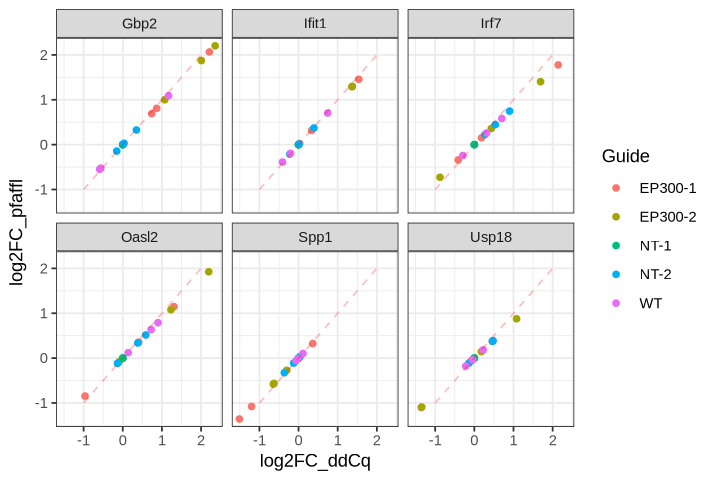

In [55]:
ggplot(results, aes(x=log2FC_ddCq, y=log2FC_pfaffl)) +
  geom_point(aes(color=Guide)) +
  facet_wrap(~Primer, scales="fixed") + 
annotate("segment", x = -1, y = -1, xend = 2, yend = 2, 
           color = "red", linetype = "dashed", alpha=0.25) +
theme_bw()

## Statistical analysis 

In [56]:
# For each Primer, Guide (excluding NT-1, as it is the control) combination, t-test log2FC vs 0
stat_results <- results %>%
  filter(Guide != "NT-1") %>%
  group_by(Primer, Guide) %>%
  summarize(
    n          = n(),
      # ddCq
    mean_log2FC_ddCq  = mean(log2FC_ddCq, na.rm=TRUE),
    sd_log2FC_ddCq    = sd(log2FC_ddCq, na.rm=TRUE),
    # t_pvalue_ddCq   = t.test(log2FC_ddCq, mu=0)$p.value, # same as paired below
    t_pvalue_ddCq   = t.test(log2FC_ddCq, c(0,0,0), paired=TRUE)$p.value,
      # pfaffl
    mean_log2FC_pfaffl  = mean(log2FC_pfaffl, na.rm=TRUE),
    sd_log2FC_pfaffl    = sd(log2FC_pfaffl, na.rm=TRUE),
    # t_pvalue_pfaffl   = t.test(log2FC_pfaffl, mu=0)$p.value, # same as paired below
    t_pvalue_pfaffl   = t.test(log2FC_pfaffl, c(0,0,0), paired=TRUE)$p.value,
    .groups    = "drop"
  )

print(dim(stat_results))
head(stat_results)

[1] 24  9


Primer,Guide,n,mean_log2FC_ddCq,sd_log2FC_ddCq,t_pvalue_ddCq,mean_log2FC_pfaffl,sd_log2FC_pfaffl,t_pvalue_pfaffl
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gbp2,EP300-1,3,1.272954673,0.8159086,0.11399710,1.188683311,0.7618943,0.11399710
Gbp2,EP300-2,3,1.812252087,0.6656447,0.04214768,1.692278489,0.6215781,0.04214768
Gbp2,NT-2,3,0.076047765,0.2547092,0.65657196,0.071013298,0.2378471,0.65657196
Gbp2,WT,3,0.005960958,1.0063378,0.99274552,0.005566335,0.9397169,0.99274552
Ifit1,EP300-1,3,0.633535567,0.7993648,0.30349441,0.599223910,0.7560720,0.30349441
Ifit1,EP300-2,3,0.912711953,0.7904649,0.18351484,0.863280382,0.7476541,0.18351484


# A tibble: 6 × 2
  Primer correlation
  <chr>        <dbl>
1 Gbp2             1
2 Ifit1            1
3 Irf7             1
4 Oasl2            1
5 Spp1             1
6 Usp18            1


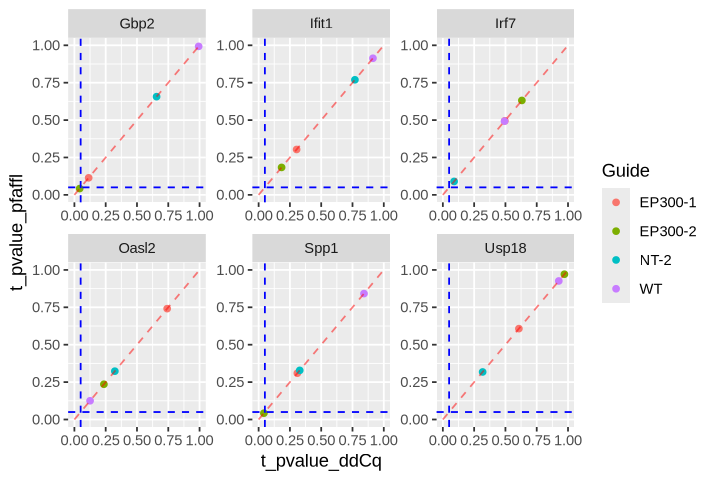

In [57]:
# compare p-values
pval_corr <- stat_results %>%
  group_by(Primer) %>%
  summarize(correlation = cor(t_pvalue_ddCq, t_pvalue_pfaffl, use = "complete.obs"), .groups = "drop")
print(pval_corr)

ggplot(stat_results, aes(x=t_pvalue_ddCq, y=t_pvalue_pfaffl)) +
  geom_point(aes(color=Guide)) +
  facet_wrap(~Primer, scales="free") +
annotate("segment", x = 0, y = 0, xend = 1, yend = 1, 
           color = "red", linetype = "dashed", alpha=0.5) +
geom_hline(yintercept = 0.05, linetype = "dashed", color = "blue") +
  geom_vline(xintercept = 0.05, linetype = "dashed", color = "blue")


## Save results

In [58]:
# save results
write_csv(results, file.path(data_path, "Ep300_ko_untreated_pfaffl_qPCR_results.csv"))
write_csv(stat_results, file.path(data_path, "Ep300_ko_untreated_pfaffl_qPCR_statistics.csv"))

## Visualization 

In [59]:
width <- 6
height <- 4
options(repr.plot.width=width, repr.plot.height=height)

In [60]:
# remove NT-1 data for plotting and reorder columns
results_plot <- results %>%
  filter(Guide != "NT-1")%>%
mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Guide   = factor(Guide,   levels = c("NT-2","WT", "EP300-1","EP300-2"))
  )

In [61]:
# mark p-values <= 0.05 with an asterisk
stats_results <- stat_results %>%
mutate(sig_label = ifelse(t_pvalue_pfaffl <= 0.05, "*", ""))

star_positions <- results_plot %>%
  group_by(Primer, Guide) %>%
  summarize(
    ypos = max(log2FC_pfaffl, na.rm = TRUE),
    .groups = "drop"
  )

stats_for_plot <- star_positions %>%
  left_join(stats_results, by = c("Primer","Guide"))%>%
  mutate(
    Primer = factor(Primer, levels = c("Spp1","Gbp2","Ifit1","Irf7","Oasl2","Usp18")),
    Guide   = factor(Guide,   levels = c("NT-2","WT", "EP300-1","EP300-2"))
  )

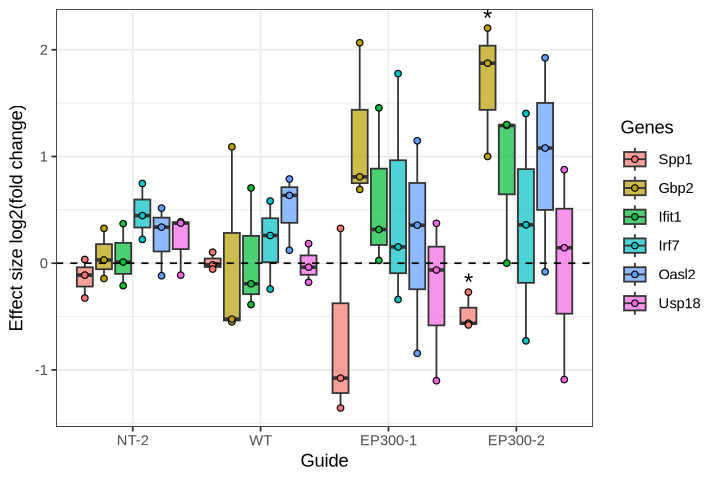

In [62]:
# plot as box plots
p_results <- results_plot %>%
  ggplot(aes(
    x      = Guide, 
    y      = log2FC_pfaffl, 
    fill   = Primer
  ), color  = "black") +
  # Boxplot, grouped by both Guide & Primer
  geom_boxplot(
    aes(group = interaction(Guide, Primer)),
    position = position_dodge(width = 0.9),
    alpha    = 0.7,
    outlier.shape = NA
  ) +
  # replicate points
  geom_point(
    aes(group = interaction(Guide, Primer)),
    position = position_dodge(width=0.9),
    size     = 1.5,
    shape    = 21,
    stroke   = 0.5
  ) +
  # Horizontal reference line at 0
  geom_hline(yintercept = 0, linetype = "dashed") +
  # Facet in one row
  # facet_wrap(~ Timepoint + Stimulation, ncol = 4, scales = "fixed") +
  # Axis & legend labels
  labs(
    x    = "Guide",
    y    = "Effect size log2(fold change)",
    fill = "Genes",
    color= "Genes"
  ) +
  theme_bw() +
  # Add significance stars (if p<=0.05 => "*")
    geom_text(
        data     = stats_for_plot,
        aes(group = interaction(Guide, Primer),
            y     = ypos,
           label=sig_label
           ),
            position = position_dodge(width = 0.9),
    vjust    = -0.1,
    size     = 5,
    )+
scale_color_identity(guide = "none")

p_results

In [63]:
# save plot
ggsave_new(filename="Ep300_ko_untreated_pfaffl_qPCR",
           results_path=data_path,
           plot=p_results+ macro_theme(),
           width=width,
           height=height
          )